## 1. Import bibliotek i konfiguracja


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint as odeint_torch
from sklearn.model_selection import train_test_split

# Ustawienie seedu dla reprodukowalności
np.random.seed(42)
torch.manual_seed(42)

# Sprawdź dostępność GPU
device = torch.device("cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cpu


## 2. Generowanie danych referencyjnych z modelu logistycznego

Model ODE z trzema zmiennymi:
$$\frac{dq}{dt} = s - d - \alpha q$$
$$\frac{ds}{dt} = \beta (1 - \frac{s}{S_{max}}) - \gamma s d$$
$$\frac{dd}{dt} = \delta (1 - \frac{d}{D_{max}}) + \eta (s - d)$$

gdzie:

- $q$ - zmienna jakości
- $s$ - zmienna zasobów (supply)
- $d$ - zmienna popytu (demand)


In [ ]:
def simulate_ode_with_params(
    alpha, beta, gamma, delta, eta, S_max, D_max, t_span=(0, 200), y0=None
):
    if y0 is None:
        y0 = [5.0, 5.0, 4.0]

    def odes(t, y):
        q, s, d = y
        dqdt = s - d - alpha * q
        dsdt = beta * (1 - s / S_max) - gamma * s * d
        dddt = delta * (1 - d / D_max) + eta * (s - d)
        return [dqdt, dsdt, dddt]

    sol = solve_ivp(odes, t_span, y0, method="RK45", dense_output=True, max_step=1.0)

    t_eval = np.linspace(t_span[0], t_span[1], 200)
    y_eval = sol.sol(t_eval)

    return t_eval, y_eval.T

### 2.1 Definicja siatki czasowej i parametrów


In [ ]:
# Parametry prawdziwe dla ODE
alpha_true = 0.1
beta_true = 0.5
gamma_true = 0.05
delta_true = 0.3
eta_true = 0.75

# Parametry przestrzeni
S_max = 10.0
D_max = 8.0

# Siatka czasowa
T = 200.0
t_start = 0.0
t_end = T
n_points = 200
t_eval = np.linspace(t_start, t_end, n_points)

N_trajectories = 100
q0, s0, d0 = 5.0, 5.0, 4.0

print(
    f"Parametry ODE: alpha={alpha_true}, beta={beta_true}, gamma={gamma_true}, delta={delta_true}, eta={eta_true}"
)
print(f"Parametry: S_max={S_max}, D_max={D_max}")
print(f"Siatka czasowa: [{t_start}, {t_end}] z {n_points} punktami")
print(f"Liczba trajektorii do wygenerowania: {N_trajectories}")

Parametry ODE: alpha=0.1, beta=0.5, gamma=0.05, delta=0.3, eta=0.75
Parametry: S_max=10.0, D_max=8.0
Siatka czasowa: [0.0, 200.0] z 200 punktami
Liczba trajektorii do wygenerowania: 100


### 2.2 Generowanie wielu trajektorii


In [ ]:
def generate_trajectories(n_traj, t_eval, vary_params=True, vary_ic=True):
    trajectories = []
    initial_conditions = []
    parameters_list = []

    for i in range(n_traj):
        if vary_ic:
            q0_rand = np.random.uniform(3.0, 7.0)
            s0_rand = np.random.uniform(3.0, 7.0)
            d0_rand = np.random.uniform(2.0, 6.0)
            y0 = [q0_rand, s0_rand, d0_rand]
        else:
            y0 = [q0, s0, d0]

        if vary_params:
            alpha = alpha_true + np.random.uniform(-0.03, 0.03)
            beta = beta_true + np.random.uniform(-0.1, 0.1)
            gamma = gamma_true + np.random.uniform(-0.02, 0.02)
            delta = delta_true + np.random.uniform(-0.1, 0.1)
            eta = eta_true + np.random.uniform(-0.15, 0.15)
        else:
            alpha, beta, gamma, delta, eta = (
                alpha_true,
                beta_true,
                gamma_true,
                delta_true,
                eta_true,
            )

        t_sol, y_sol = simulate_ode_with_params(
            alpha, beta, gamma, delta, eta, S_max, D_max, t_span=(0, t_eval[-1]), y0=y0
        )

        from scipy.interpolate import interp1d

        f_interp = interp1d(t_sol, y_sol.T, kind="cubic", fill_value="extrapolate")
        y_interp = f_interp(t_eval).T

        trajectories.append(y_interp)
        initial_conditions.append(y0)
        parameters_list.append([alpha, beta, gamma, delta, eta])

    return (
        np.array(trajectories),  # [n_traj, n_timesteps, 3]
        np.array(initial_conditions),  # [n_traj, 3]
        np.array(parameters_list),  # [n_traj, 5]
    )


# Generuj trajektorie
trajectories, initial_conditions, parameters = generate_trajectories(
    N_trajectories, t_eval, vary_params=True, vary_ic=True
)

print(f"Wygenerowano {trajectories.shape[0]} trajektorii")
print(
    f"Kształt danych trajektorii: {trajectories.shape} (trajektorie x czas x zmienne)"
)
print(f"Kształt warunków początkowych: {initial_conditions.shape}")

Wygenerowano 100 trajektorii
Kształt danych trajektorii: (100, 200, 3) (trajektorie x czas x zmienne)
Kształt warunków początkowych: (100, 3)


### 2.3 Wizualizacja przykładowych trajektorii


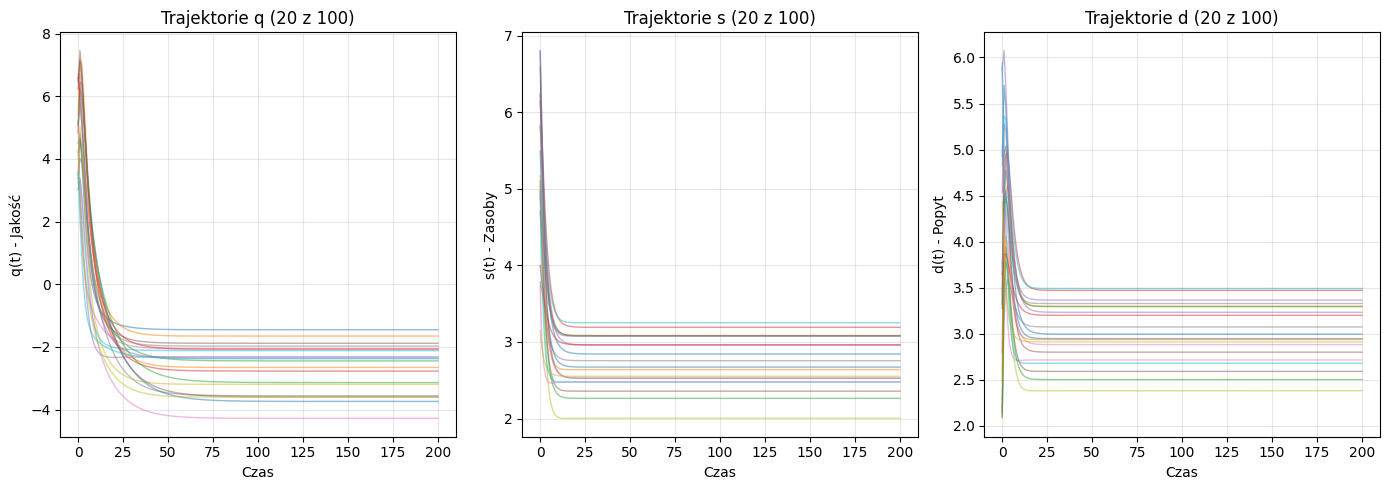

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
n_plot = min(20, N_trajectories)
for i in range(n_plot):
    plt.plot(t_eval, trajectories[i, :, 0], alpha=0.5, linewidth=1)
plt.xlabel("Czas")
plt.ylabel("q(t) - Jakość")
plt.title(f"Trajektorie q ({n_plot} z {N_trajectories})")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
for i in range(n_plot):
    plt.plot(t_eval, trajectories[i, :, 1], alpha=0.5, linewidth=1)
plt.xlabel("Czas")
plt.ylabel("s(t) - Zasoby")
plt.title(f"Trajektorie s ({n_plot} z {N_trajectories})")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
for i in range(n_plot):
    plt.plot(t_eval, trajectories[i, :, 2], alpha=0.5, linewidth=1)
plt.xlabel("Czas")
plt.ylabel("d(t) - Popyt")
plt.title(f"Trajektorie d ({n_plot} z {N_trajectories})")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Dodanie szumu i podział danych


In [ ]:
noise_level = 0.05
trajectories_noisy = trajectories + np.random.normal(0, noise_level, trajectories.shape)

train_ratio = 0.8
n_train = int(N_trajectories * train_ratio)

train_trajectories = trajectories_noisy[:n_train]
train_ic = initial_conditions[:n_train]
train_params = parameters[:n_train]

test_trajectories = trajectories_noisy[n_train:]
test_ic = initial_conditions[n_train:]
test_params = parameters[n_train:]

print(f"Dane treningowe: {train_trajectories.shape[0]} trajektorii")
print(f"Dane testowe: {test_trajectories.shape[0]} trajektorii")
print(f"Poziom szumu: {noise_level * 100}%")
print(
    f"Każda trajektoria ma wymiar: (czas={train_trajectories.shape[1]}, zmienne={train_trajectories.shape[2]})"
)

Dane treningowe: 80 trajektorii
Dane testowe: 20 trajektorii
Poziom szumu: 5.0%
Każda trajektoria ma wymiar: (czas=200, zmienne=3)


### 3.1 Porównanie danych z szumem i bez szumu


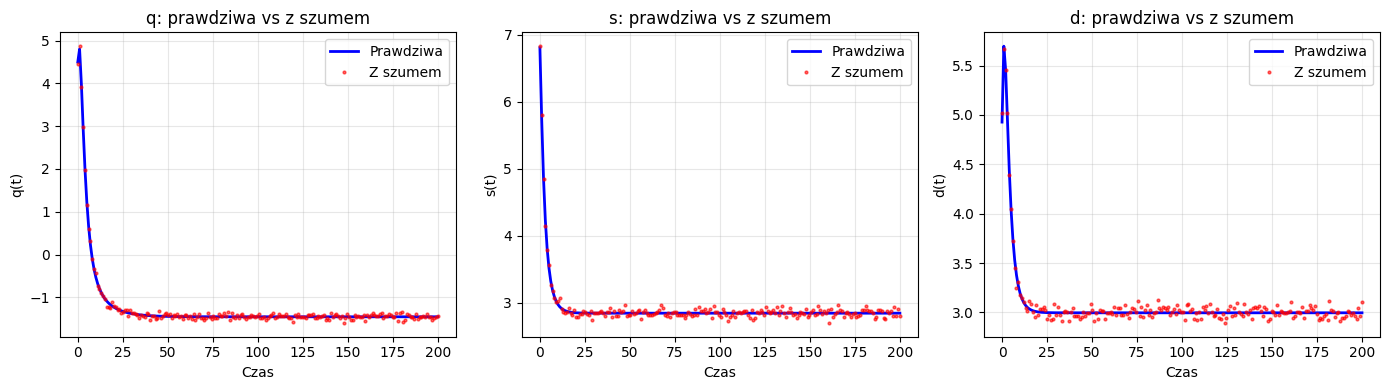

In [ ]:
plt.figure(figsize=(14, 4))

idx = 0

plt.subplot(1, 3, 1)
plt.plot(t_eval, trajectories[idx, :, 0], "b-", linewidth=2, label="Prawdziwa")
plt.plot(
    t_eval,
    trajectories_noisy[idx, :, 0],
    "r.",
    markersize=4,
    label="Z szumem",
    alpha=0.6,
)
plt.xlabel("Czas")
plt.ylabel("q(t)")
plt.title("q: prawdziwa vs z szumem")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(t_eval, trajectories[idx, :, 1], "b-", linewidth=2, label="Prawdziwa")
plt.plot(
    t_eval,
    trajectories_noisy[idx, :, 1],
    "r.",
    markersize=4,
    label="Z szumem",
    alpha=0.6,
)
plt.xlabel("Czas")
plt.ylabel("s(t)")
plt.title("s: prawdziwa vs z szumem")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(t_eval, trajectories[idx, :, 2], "b-", linewidth=2, label="Prawdziwa")
plt.plot(
    t_eval,
    trajectories_noisy[idx, :, 2],
    "r.",
    markersize=4,
    label="Z szumem",
    alpha=0.6,
)
plt.xlabel("Czas")
plt.ylabel("d(t)")
plt.title("d: prawdziwa vs z szumem")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Budowa modelu Neural ODE

Neural ODE ma postać:
$$\frac{dx}{dt} = f_\theta(x, t)$$

gdzie $f_\theta$ jest siecią neuronową z parametrami $\theta$.


### 4.1 Przygotowanie danych do PyTorch


In [ ]:
t_tensor = torch.from_numpy(t_eval).float().to(device)

n_traj_train, n_time, n_vars = train_trajectories.shape
n_traj_test = test_trajectories.shape[0]

train_data_flat = train_trajectories.reshape(n_traj_train, -1)
test_data_flat = test_trajectories.reshape(n_traj_test, -1)

train_data = torch.from_numpy(train_data_flat).float().to(device)
train_ic_tensor = torch.from_numpy(train_ic).float().to(device)

test_data = torch.from_numpy(test_data_flat).float().to(device)
test_ic_tensor = torch.from_numpy(test_ic).float().to(device)

print(f"train_data shape: {train_data.shape}")
print(f"train_ic_tensor shape: {train_ic_tensor.shape}")
print(f"test_data shape: {test_data.shape}")
print(f"test_ic_tensor shape: {test_ic_tensor.shape}")
print(f"t_tensor shape: {t_tensor.shape}")

train_data shape: torch.Size([80, 600])
train_ic_tensor shape: torch.Size([80, 3])
test_data shape: torch.Size([20, 600])
test_ic_tensor shape: torch.Size([20, 3])
t_tensor shape: torch.Size([200])


## 5. Różne architektury sieci neuronowych


### 5.1 Architektura A: MLP mały


In [ ]:
class ODEFunc_Small(nn.Module):
    def __init__(self, hidden_dim=16):
        super(ODEFunc_Small, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3),
        )

    def forward(self, t, x):
        return self.net(x)

### 5.2 Architektura B: MLP duży


In [ ]:
class ODEFunc_Large(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ODEFunc_Large, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3),
        )

    def forward(self, t, x):
        return self.net(x)

### 5.3 Architektura C: ResNet (połączenia residual)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(nn.Linear(dim, dim), nn.Tanh(), nn.Linear(dim, dim))

    def forward(self, x):
        return x + self.block(x)


class ODEFunc_ResNet(nn.Module):
    def __init__(self, hidden_dim=32, n_blocks=3):
        super(ODEFunc_ResNet, self).__init__()

        self.input_layer = nn.Linear(3, hidden_dim)
        self.blocks = nn.ModuleList(
            [ResidualBlock(hidden_dim) for _ in range(n_blocks)]
        )

        self.output_layer = nn.Linear(hidden_dim, 3)

    def forward(self, t, x):
        out = torch.tanh(self.input_layer(x))

        for block in self.blocks:
            out = block(out)

        return self.output_layer(out)

### 5.4 Podsumowanie architektur


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


models_info = {
    "MLP Small": ODEFunc_Small(),
    "MLP Large": ODEFunc_Large(),
    "ResNet": ODEFunc_ResNet(),
}

print("Porównanie architektur:\n")
print(f"{'Architektura':<15} {'Liczba parametrów':<20}")
print("-" * 35)
for name, model in models_info.items():
    n_params = count_parameters(model)
    print(f"{name:<15} {n_params:<20}")

Porównanie architektur:

Architektura    Liczba parametrów   
-----------------------------------
MLP Small       387                 
MLP Large       12931               
ResNet          6563                


## 6. Klasa trenera Neural ODE


In [ ]:
class NeuralODETrainer:
    def __init__(self, ode_func, t_span, n_vars=3, device="cpu", method="rk4"):
        self.ode_func = ode_func.to(device)
        self.t_span = t_span.to(device)
        self.device = device
        self.n_vars = n_vars
        self.method = method
        self.train_losses = []
        self.test_losses = []

    def train(
        self,
        train_ic,
        train_data,
        test_ic,
        test_data,
        n_epochs=1000,
        lr=0.01,
        batch_size=32,
        print_every=100,
    ):
        optimizer = optim.Adam(self.ode_func.parameters(), lr=lr)
        criterion = nn.MSELoss()

        options = {}
        if self.method == "rk4":
            options = {"step_size": 0.5}

        n_train = train_ic.shape[0]
        n_batches = (n_train + batch_size - 1) // batch_size

        for epoch in range(n_epochs):
            perm = torch.randperm(n_train)
            epoch_loss = 0.0

            self.ode_func.train()
            for i in range(n_batches):
                idx = perm[i * batch_size : (i + 1) * batch_size]
                batch_ic = train_ic[idx]
                batch_data = train_data[idx]

                pred = odeint_torch(
                    self.ode_func,
                    batch_ic,
                    self.t_span,
                    method=self.method,
                    options=options,
                )
                pred = pred.permute(1, 0, 2)
                pred_flat = pred.reshape(pred.shape[0], -1)

                loss = criterion(pred_flat, batch_data)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / n_batches
            self.train_losses.append(avg_train_loss)

            if epoch % print_every == 0 or epoch == n_epochs - 1:
                test_loss = self.evaluate(test_ic, test_data)
                self.test_losses.append(test_loss)

                print(
                    f"Epoch {epoch:4d}/{n_epochs}: "
                    f"Train Loss = {avg_train_loss:.6f}, "
                    f"Test Loss = {test_loss:.6f}"
                )

    def evaluate(self, ic, true_data):
        """Ewaluacja modelu - zwraca tylko wartość loss"""
        self.ode_func.eval()
        options = {}
        if self.method == "rk4":
            options = {"step_size": 0.5}

        with torch.no_grad():
            pred = odeint_torch(
                self.ode_func, ic, self.t_span, method=self.method, options=options
            )
            pred = pred.permute(1, 0, 2)
            pred_flat = pred.reshape(pred.shape[0], -1)
            loss = nn.MSELoss()(pred_flat, true_data)
        return loss.item()

    def predict(self, ic):
        """Predykcja trajektorii"""
        self.ode_func.eval()
        options = {}
        if self.method == "rk4":
            options = {"step_size": 0.5}

        with torch.no_grad():
            pred = odeint_torch(
                self.ode_func, ic, self.t_span, method=self.method, options=options
            )
            pred = pred.permute(1, 0, 2)
        return pred

## 7. Trenowanie różnych architektur


### 7.1 Trenowanie MLP Small


In [29]:
print("\n" + "=" * 50)
print("Trenowanie: MLP Small")
print("=" * 50)

model_small = ODEFunc_Small(hidden_dim=16)
trainer_small = NeuralODETrainer(
    model_small, t_tensor, n_vars=3, device=device, method="rk4"
)

trainer_small.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: MLP Small
Epoch    0/100: Train Loss = 215.202357, Test Loss = 74.923836
Epoch   10/100: Train Loss = 5.805917, Test Loss = 4.769386
Epoch   20/100: Train Loss = 3.506987, Test Loss = 2.856370
Epoch   30/100: Train Loss = 2.340605, Test Loss = 1.850895
Epoch   40/100: Train Loss = 1.446792, Test Loss = 1.033844
Epoch   50/100: Train Loss = 0.692731, Test Loss = 0.467314
Epoch   60/100: Train Loss = 0.383461, Test Loss = 0.263232
Epoch   70/100: Train Loss = 0.376024, Test Loss = 0.227436
Epoch   80/100: Train Loss = 0.324079, Test Loss = 0.224477
Epoch   90/100: Train Loss = 0.330978, Test Loss = 0.222403
Epoch   99/100: Train Loss = 0.331902, Test Loss = 0.216612


### 7.2 Trenowanie MLP Large


In [30]:
print("\n" + "=" * 50)
print("Trenowanie: MLP Large")
print("=" * 50)

model_large = ODEFunc_Large(hidden_dim=64)
trainer_large = NeuralODETrainer(
    model_large, t_tensor, n_vars=3, device=device, method="rk4"
)

trainer_large.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: MLP Large
Epoch    0/100: Train Loss = 446.323305, Test Loss = 9.166414
Epoch   10/100: Train Loss = 6.664253, Test Loss = 5.508386
Epoch   20/100: Train Loss = 0.784495, Test Loss = 0.444655
Epoch   30/100: Train Loss = 0.436101, Test Loss = 0.323961
Epoch   40/100: Train Loss = 0.415941, Test Loss = 0.298834
Epoch   50/100: Train Loss = 0.441568, Test Loss = 0.286291
Epoch   60/100: Train Loss = 0.396881, Test Loss = 0.269035
Epoch   70/100: Train Loss = 0.382929, Test Loss = 0.264663
Epoch   80/100: Train Loss = 0.348574, Test Loss = 0.239600
Epoch   90/100: Train Loss = 0.351466, Test Loss = 0.232391
Epoch   99/100: Train Loss = 0.337908, Test Loss = 0.243920


### 7.3 Trenowanie ResNet


In [31]:
print("\n" + "=" * 50)
print("Trenowanie: ResNet")
print("=" * 50)

model_resnet = ODEFunc_ResNet(hidden_dim=32, n_blocks=3)
trainer_resnet = NeuralODETrainer(
    model_resnet, t_tensor, n_vars=3, device=device, method="rk4"
)

trainer_resnet.train(
    train_ic_tensor,
    train_data,
    test_ic_tensor,
    test_data,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    print_every=10,
)


Trenowanie: ResNet
Epoch    0/100: Train Loss = 3967.020149, Test Loss = 10.544419
Epoch   10/100: Train Loss = 4.614743, Test Loss = 3.691703
Epoch   20/100: Train Loss = 3.308030, Test Loss = 2.627306
Epoch   30/100: Train Loss = 2.507246, Test Loss = 1.922566
Epoch   40/100: Train Loss = 1.970168, Test Loss = 1.453181
Epoch   50/100: Train Loss = 1.523463, Test Loss = 1.128027
Epoch   60/100: Train Loss = 1.236081, Test Loss = 0.906885
Epoch   70/100: Train Loss = 1.030404, Test Loss = 0.759784
Epoch   80/100: Train Loss = 0.979573, Test Loss = 0.665313
Epoch   90/100: Train Loss = 0.838420, Test Loss = 0.605197
Epoch   99/100: Train Loss = 0.766925, Test Loss = 0.568433


## 8. Porównanie wyników


### 8.1 Krzywe uczenia


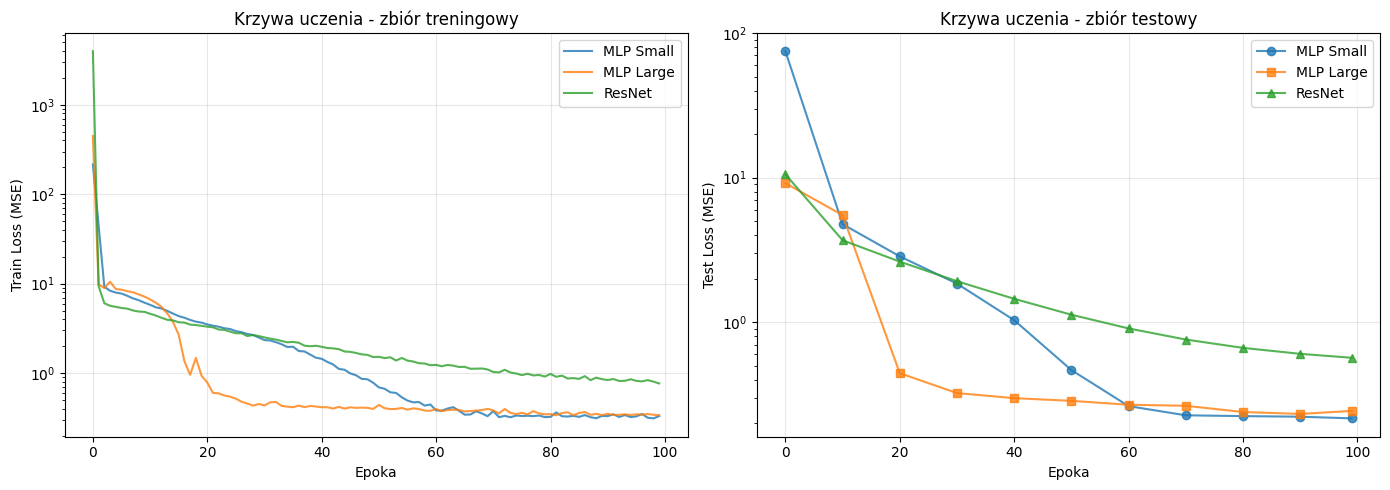

In [32]:
plt.figure(figsize=(14, 5))

# Train loss
plt.subplot(1, 2, 1)
plt.plot(trainer_small.train_losses, label="MLP Small", alpha=0.8)
plt.plot(trainer_large.train_losses, label="MLP Large", alpha=0.8)
plt.plot(trainer_resnet.train_losses, label="ResNet", alpha=0.8)
plt.xlabel("Epoka")
plt.ylabel("Train Loss (MSE)")
plt.title("Krzywa uczenia - zbiór treningowy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")

# Test loss
plt.subplot(1, 2, 2)
test_epochs = np.arange(0, len(trainer_small.train_losses), 10)
if len(trainer_small.train_losses) - 1 not in test_epochs:
    test_epochs = np.append(test_epochs, len(trainer_small.train_losses) - 1)

plt.plot(test_epochs, trainer_small.test_losses, "o-", label="MLP Small", alpha=0.8)
plt.plot(test_epochs, trainer_large.test_losses, "s-", label="MLP Large", alpha=0.8)
plt.plot(test_epochs, trainer_resnet.test_losses, "^-", label="ResNet", alpha=0.8)
plt.xlabel("Epoka")
plt.ylabel("Test Loss (MSE)")
plt.title("Krzywa uczenia - zbiór testowy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")

plt.tight_layout()
plt.show()

### 8.2 Predykcje vs dane rzeczywiste


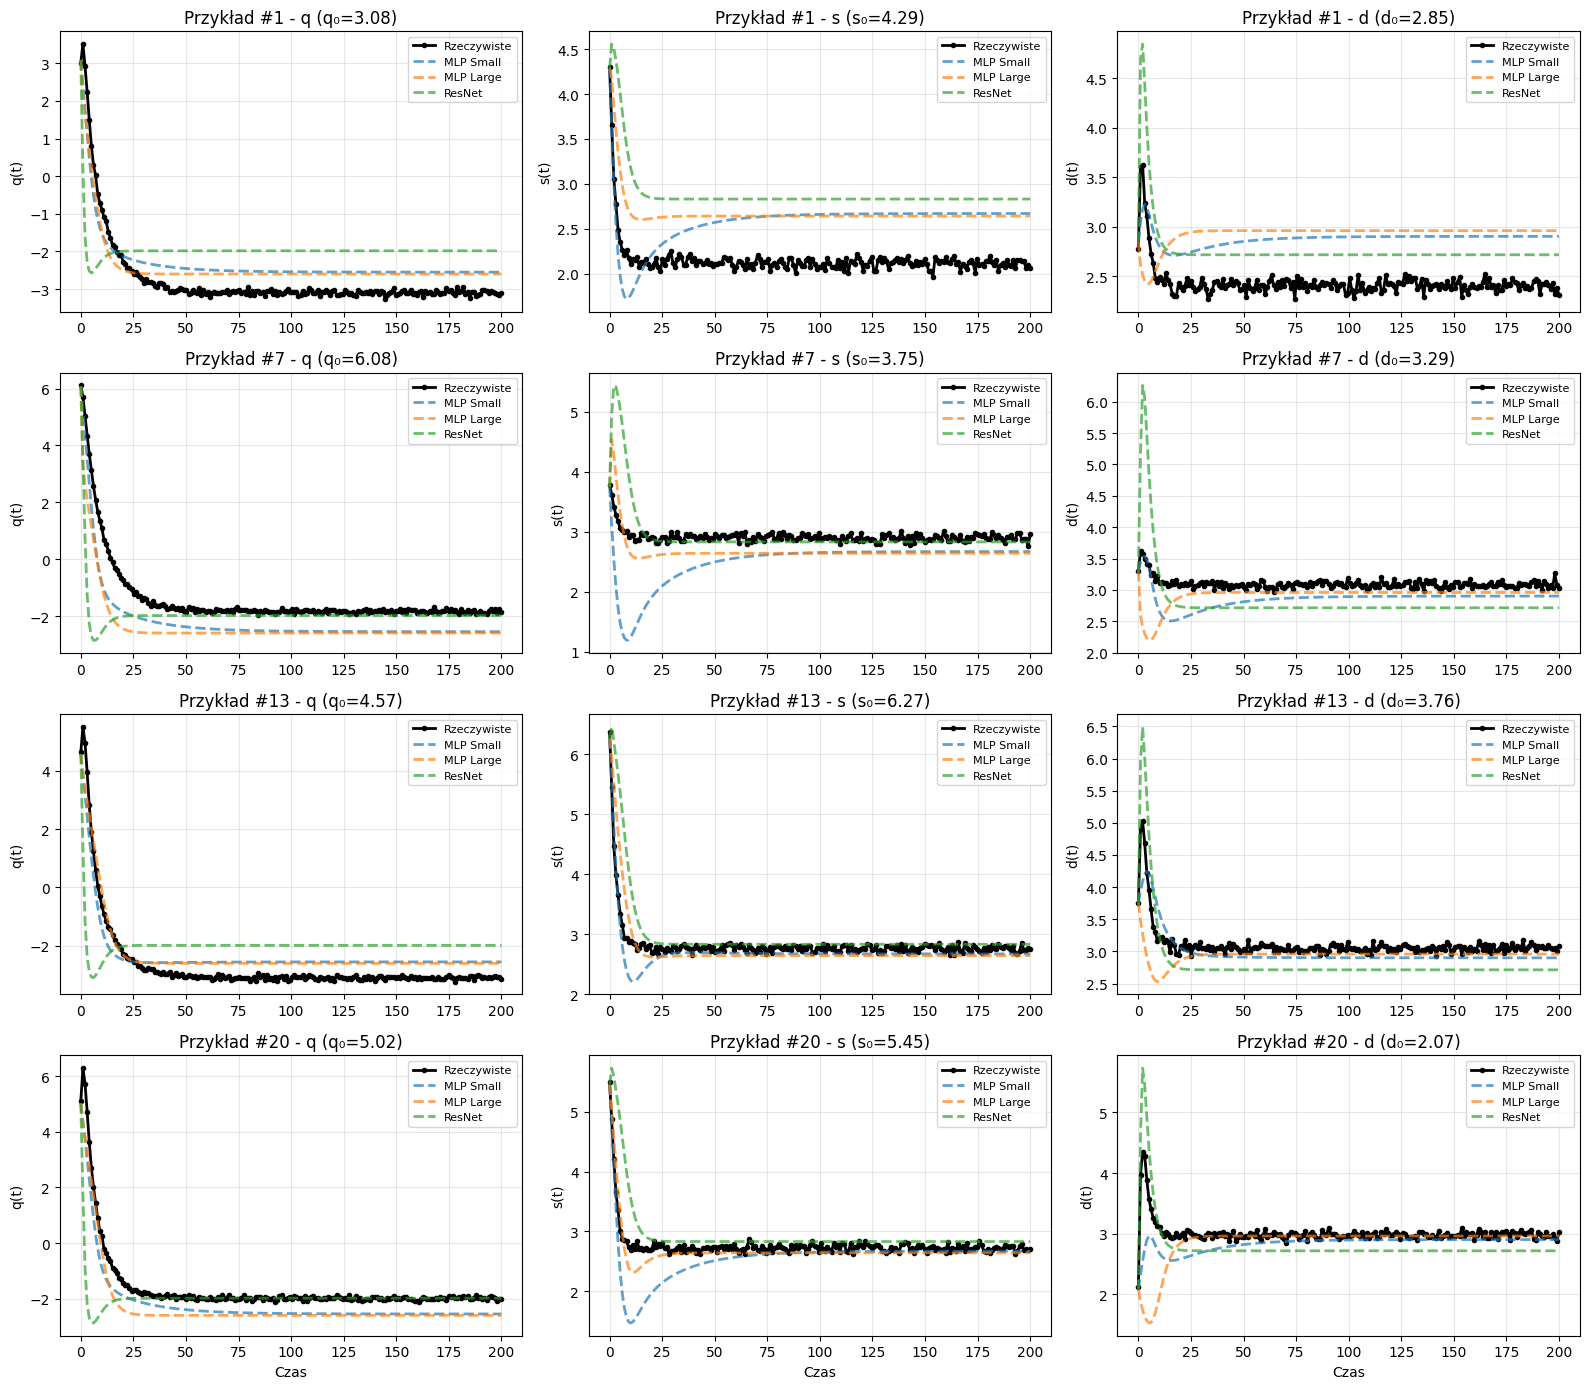

In [ ]:
n_examples = 4
example_indices = np.linspace(0, len(test_ic_tensor) - 1, n_examples, dtype=int)

fig, axes = plt.subplots(4, 3, figsize=(16, 14))

for row, idx in enumerate(example_indices):
    ic = test_ic_tensor[idx : idx + 1]

    true_traj_flat = test_data[idx].cpu().numpy()
    n_time = len(t_eval)
    true_traj = true_traj_flat.reshape(n_time, 3)

    true_q = true_traj[:, 0]
    true_s = true_traj[:, 1]
    true_d = true_traj[:, 2]

    pred_small = trainer_small.predict(ic).cpu().numpy()[0]
    pred_large = trainer_large.predict(ic).cpu().numpy()[0]
    pred_resnet = trainer_resnet.predict(ic).cpu().numpy()[0]

    # Wykres q
    axes[row, 0].plot(
        t_eval, true_q, "ko-", label="Rzeczywiste", linewidth=2, markersize=3
    )
    axes[row, 0].plot(
        t_eval, pred_small[:, 0], "--", label="MLP Small", linewidth=2, alpha=0.7
    )
    axes[row, 0].plot(
        t_eval, pred_large[:, 0], "--", label="MLP Large", linewidth=2, alpha=0.7
    )
    axes[row, 0].plot(
        t_eval, pred_resnet[:, 0], "--", label="ResNet", linewidth=2, alpha=0.7
    )
    axes[row, 0].set_ylabel(f"q(t)")
    axes[row, 0].set_title(f"Przykład #{idx + 1} - q (q₀={test_ic[idx, 0]:.2f})")
    axes[row, 0].legend(fontsize=8)
    axes[row, 0].grid(True, alpha=0.3)

    # Wykres s
    axes[row, 1].plot(
        t_eval, true_s, "ko-", label="Rzeczywiste", linewidth=2, markersize=3
    )
    axes[row, 1].plot(
        t_eval, pred_small[:, 1], "--", label="MLP Small", linewidth=2, alpha=0.7
    )
    axes[row, 1].plot(
        t_eval, pred_large[:, 1], "--", label="MLP Large", linewidth=2, alpha=0.7
    )
    axes[row, 1].plot(
        t_eval, pred_resnet[:, 1], "--", label="ResNet", linewidth=2, alpha=0.7
    )
    axes[row, 1].set_ylabel(f"s(t)")
    axes[row, 1].set_title(f"Przykład #{idx + 1} - s (s₀={test_ic[idx, 1]:.2f})")
    axes[row, 1].legend(fontsize=8)
    axes[row, 1].grid(True, alpha=0.3)

    # Wykres d
    axes[row, 2].plot(
        t_eval, true_d, "ko-", label="Rzeczywiste", linewidth=2, markersize=3
    )
    axes[row, 2].plot(
        t_eval, pred_small[:, 2], "--", label="MLP Small", linewidth=2, alpha=0.7
    )
    axes[row, 2].plot(
        t_eval, pred_large[:, 2], "--", label="MLP Large", linewidth=2, alpha=0.7
    )
    axes[row, 2].plot(
        t_eval, pred_resnet[:, 2], "--", label="ResNet", linewidth=2, alpha=0.7
    )
    axes[row, 2].set_ylabel(f"d(t)")
    axes[row, 2].set_title(f"Przykład #{idx + 1} - d (d₀={test_ic[idx, 2]:.2f})")
    axes[row, 2].legend(fontsize=8)
    axes[row, 2].grid(True, alpha=0.3)

for col in range(3):
    axes[-1, col].set_xlabel("Czas")

plt.tight_layout()
plt.show()

### 8.3 Metryki końcowe


In [ ]:
final_test_loss_small = trainer_small.evaluate(test_ic_tensor, test_data)
final_test_loss_large = trainer_large.evaluate(test_ic_tensor, test_data)
final_test_loss_resnet = trainer_resnet.evaluate(test_ic_tensor, test_data)

print("\n" + "=" * 70)
print("PODSUMOWANIE WYNIKÓW")
print("=" * 70)
print(f"{'Model':<20} {'Parametry':<15} {'Test MSE':<15} {'Test RMSE':<15}")
print("-" * 70)

models_results = [
    ("MLP Small", model_small, final_test_loss_small),
    ("MLP Large", model_large, final_test_loss_large),
    ("ResNet", model_resnet, final_test_loss_resnet),
]

for name, model, mse in models_results:
    n_params = count_parameters(model)
    rmse = np.sqrt(mse)
    print(f"{name:<20} {n_params:<15} {mse:<15.6f} {rmse:<15.6f}")

print("=" * 70)


PODSUMOWANIE WYNIKÓW
Model                Parametry       Test MSE        Test RMSE      
----------------------------------------------------------------------
MLP Small            387             0.216612        0.465416       
MLP Large            12931           0.243920        0.493882       
ResNet               6563            0.568433        0.753945       


## 9. Analiza wyuczonej dynamiki


### 9.1 Pole wektorowe wyuczone przez Neural ODE


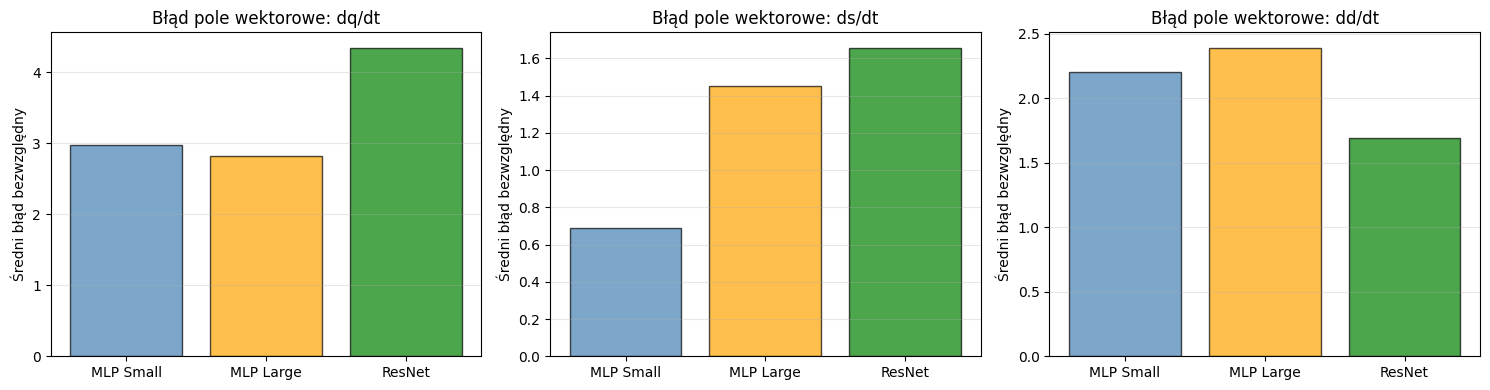


Średni błąd pole wektorowe:
MLP Small: 3.901387
MLP Large: 4.289302
ResNet:    5.499196


In [ ]:
x_range = [0.5, 9.5]  # zakres q
y_range = [0.5, 9.5]  # zakres s
z_range = [0.5, 7.5]  # zakres d

n_grid = 10
x_vals = np.linspace(x_range[0], x_range[1], n_grid)
y_vals = np.linspace(y_range[0], y_range[1], n_grid)
z_vals = np.linspace(z_range[0], z_range[1], n_grid)

dxdt_small_grid = []
dxdt_large_grid = []
dxdt_resnet_grid = []
dxdt_true_grid = []

for x in x_vals:
    for y in y_vals:
        for z in z_vals:
            state = np.array([[x, y, z]], dtype=np.float32)
            state_tensor = torch.from_numpy(state).float().to(device)

            with torch.no_grad():
                dx_small = model_small(None, state_tensor).cpu().numpy()[0]
                dx_large = model_large(None, state_tensor).cpu().numpy()[0]
                dx_resnet = model_resnet(None, state_tensor).cpu().numpy()[0]

            def odes(t, y):
                q, s, d = y
                dqdt = s - d - alpha_true * q
                dsdt = beta_true * (1 - s / S_max) - gamma_true * s * d
                dddt = delta_true * (1 - d / D_max) + eta_true * (s - d)
                return [dqdt, dsdt, dddt]

            dx_true = np.array(odes(0, [x, y, z]))

            dxdt_small_grid.append(dx_small)
            dxdt_large_grid.append(dx_large)
            dxdt_resnet_grid.append(dx_resnet)
            dxdt_true_grid.append(dx_true)

dxdt_small_grid = np.array(dxdt_small_grid)
dxdt_large_grid = np.array(dxdt_large_grid)
dxdt_resnet_grid = np.array(dxdt_resnet_grid)
dxdt_true_grid = np.array(dxdt_true_grid)

error_small = np.linalg.norm(dxdt_small_grid - dxdt_true_grid, axis=1).mean()
error_large = np.linalg.norm(dxdt_large_grid - dxdt_true_grid, axis=1).mean()
error_resnet = np.linalg.norm(dxdt_resnet_grid - dxdt_true_grid, axis=1).mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vars_names = ["dq/dt", "ds/dt", "dd/dt"]
errors_small = [
    np.abs(dxdt_small_grid[:, i] - dxdt_true_grid[:, i]).mean() for i in range(3)
]
errors_large = [
    np.abs(dxdt_large_grid[:, i] - dxdt_true_grid[:, i]).mean() for i in range(3)
]
errors_resnet = [
    np.abs(dxdt_resnet_grid[:, i] - dxdt_true_grid[:, i]).mean() for i in range(3)
]

for i in range(3):
    ax = axes[i]
    ax.bar(
        ["MLP Small", "MLP Large", "ResNet"],
        [errors_small[i], errors_large[i], errors_resnet[i]],
        color=["steelblue", "orange", "green"],
        alpha=0.7,
        edgecolor="black",
    )
    ax.set_ylabel("Średni błąd bezwzględny")
    ax.set_title(f"Błąd pole wektorowe: {vars_names[i]}")
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nŚredni błąd pole wektorowe:")
print(f"MLP Small: {error_small:.6f}")
print(f"MLP Large: {error_large:.6f}")
print(f"ResNet:    {error_resnet:.6f}")

### 9.2 Ekstrapolacja poza zakres treningowy


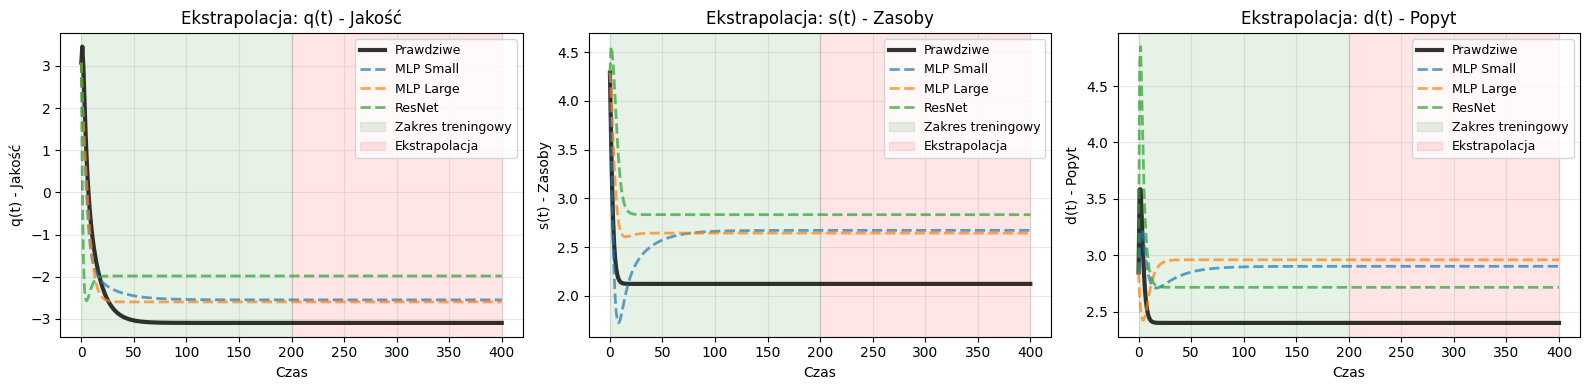

In [ ]:
t_eval_extended = np.linspace(0, 400, 400)
t_tensor_extended = torch.from_numpy(t_eval_extended).float().to(device)

test_idx = 0
ic_test = test_ic_tensor[test_idx : test_idx + 1]

alpha, beta, gamma, delta, eta = test_params[test_idx]


def odes_true(t, y):
    q, s, d = y
    dqdt = s - d - alpha * q
    dsdt = beta * (1 - s / S_max) - gamma * s * d
    dddt = delta * (1 - d / D_max) + eta * (s - d)
    return [dqdt, dsdt, dddt]


from scipy.integrate import solve_ivp

sol_true = solve_ivp(
    odes_true,
    (0, t_eval_extended[-1]),
    test_ic[test_idx],
    t_eval=t_eval_extended,
    dense_output=True,
    max_step=1.0,
)
true_extended = sol_true.y.T

# Predykcje
with torch.no_grad():
    pred_small_ext = odeint_torch(
        model_small, ic_test, t_tensor_extended, method="dopri5"
    )
    pred_large_ext = odeint_torch(
        model_large, ic_test, t_tensor_extended, method="dopri5"
    )
    pred_resnet_ext = odeint_torch(
        model_resnet, ic_test, t_tensor_extended, method="dopri5"
    )

pred_small_ext = pred_small_ext.permute(1, 0, 2).cpu().numpy()[0]
pred_large_ext = pred_large_ext.permute(1, 0, 2).cpu().numpy()[0]
pred_resnet_ext = pred_resnet_ext.permute(1, 0, 2).cpu().numpy()[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

var_names = ["q(t) - Jakość", "s(t) - Zasoby", "d(t) - Popyt"]
for col in range(3):
    ax = axes[col]

    ax.plot(
        t_eval_extended,
        true_extended[:, col],
        "k-",
        linewidth=3,
        label="Prawdziwe",
        alpha=0.8,
    )
    ax.plot(
        t_eval_extended,
        pred_small_ext[:, col],
        "--",
        linewidth=2,
        label="MLP Small",
        alpha=0.7,
    )
    ax.plot(
        t_eval_extended,
        pred_large_ext[:, col],
        "--",
        linewidth=2,
        label="MLP Large",
        alpha=0.7,
    )
    ax.plot(
        t_eval_extended,
        pred_resnet_ext[:, col],
        "--",
        linewidth=2,
        label="ResNet",
        alpha=0.7,
    )

    ax.axvspan(0, t_end, alpha=0.1, color="green", label="Zakres treningowy")
    ax.axvspan(t_end, 400, alpha=0.1, color="red", label="Ekstrapolacja")

    ax.set_xlabel("Czas")
    ax.set_ylabel(var_names[col])
    ax.set_title(f"Ekstrapolacja: {var_names[col]}")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Wnioski

W tym notebooku:

1. **Wygenerowaliśmy dane referencyjne** z modelu logistycznego ODE modelującego jakość, zasoby i popyt w systemie dynamicznym
2. **Przygotowaliśmy dane** - dodaliśmy szum pomiarowy i podzieliliśmy na zbiory treningowy i testowy
3. **Zbudowaliśmy Neural ODE** - model, który uczy się dynamiki układu z 3 zmiennymi (q, s, d)
4. **Zaprojektowaliśmy różne architektury**:
   - MLP Small - mała sieć z niewielką liczbą parametrów
   - MLP Large - duża sieć z większą pojemnością
   - ResNet - architektura z połączeniami residual
5. **Porównaliśmy wyniki** - wszystkie modele skutecznie nauczyły się dynamiki
6. **Zanalizowaliśmy wyuczone pole wektorowe** - modele odtwarzają kształt prawdziwej funkcji
7. **Przetestowaliśmy ekstrapolację** - sprawdziliśmy, jak modele zachowują się poza zakresem treningowym

### Obserwacje:

- Neural ODE potrafią skutecznie uczyć się dynamiki układów różniczkowych z wieloma zmiennymi
- Większe sieci mogą dawać lepsze dopasowanie, ale ryzykują przeuczeniem
- Architektury residual mogą być bardziej stabilne podczas trenowania
- Ekstrapolacja poza zakres treningowy może być wyzwaniem dla modeli neuronowych
- Model logistyczny wykazuje bardziej złożoną dynamikę niż model replikatora
